# Configure ZWO

> **Note:** This assumes you have properly installed the SDK Drivers available from the manufacturer. See the [install page](https://github.com/panoptes/POCS/wiki/Additional-Hardware-Drivers-Installation#zwo-asi) on the wiki for details.

POCS needs a way to refer to the invidual camera in the config file, but the ZWO cameras don't require a port (device node) like many of the other cameras. However the SDK does allow for setting a permanent name on the camera, which is stored on the cameras on-board flash memory and is persistent across power-downs.

Here we will use the low-level ASI drivers to set an initial name for the camera and then test connectivity with the POCS level drivers.

In [1]:
# Get the low-lever interaface
from pocs.camera.libasi import ASIDriver

### Open low-level device

In [4]:
zwo_driver = ASIDriver(library_path='/usr/local/lib/libASICamera2.so')

Creating AbstractSDKDriver camera: {}


In [9]:
# We are assuming right now that only one camera is plugged in
device_id = 0

In [10]:
# Open camera device
zwo_driver.open_camera(device_id)

In [11]:
# Initialize the camera
zwo_driver.init_camera(device_id)

### Assign unique camera ID

We want to assign an 8-character unique string ID to the camera. This could be a name that makes sense (i.e. `ZWOCAM01`) or a random unique identifer.

In [30]:
# Generate random id
from uuid import uuid4

# Camera can only store first 8 characters
camera_id = str(uuid4())[:8]
camera_id

'972e19f1'

In [31]:
# Set the ID
zwo_driver.set_ID(device_id, camera_id)

In [32]:
# Check the set ID
zwo_driver.get_cameras()

{'972e19f1': 0}

### Power-cycle and check new ID

Now try unplugging and powering down the camera and then re-attaching before continuing below.

In [71]:
driver_path = '/usr/local/lib/libASICamera2.so'

In [72]:
zwo_driver2 = ASIDriver(library_path=driver_path)

Creating AbstractSDKDriver camera: {}


In [73]:
cameras = zwo_driver2.get_cameras()
cameras

{'972e19f1': 0}

Great, that seemed to work. Let's update our config.

### Update Config

In [56]:
from panoptes.utils.config.client import set_config, get_config

In [99]:
set_config('cameras.devices', {'model': 'zwo', 'serial_number': camera_id, 'library_path': driver_path})

# Set this camera as the primary camera (optional)
set_config('cameras.primary', camera_id);

In [100]:
camera_config = get_config('cameras')
camera_config

{'auto_detect': True,
 'devices': {'library_path': '/usr/local/lib/libASICamera2.so',
  'model': 'zwo',
  'serial_number': '972e19f1'},
 'primary': '972e19f1'}

### Create camera object

In [76]:
from pocs.camera import create_cameras_from_config

In [78]:
from pocs.camera.zwo import Camera

In [79]:
cam0 = Camera(name='ZWOCAM01', **camera_config)
cam0

Creating AbstractSDKDriver camera: {'model': 'zwo', 'serial_number': '972e19f1', 'readout_time': 0.1, 'timeout': 0.5, 'port': None}


In [85]:
test_filename ='test_zwo.fits'

cam0.take_exposure(seconds=1., filename=test_filename, blocking=True)

In [86]:
from panoptes.utils.images import make_pretty_image

In [91]:
test_jpg = make_pretty_image(test_filename)

In [92]:
from IPython.display import Image

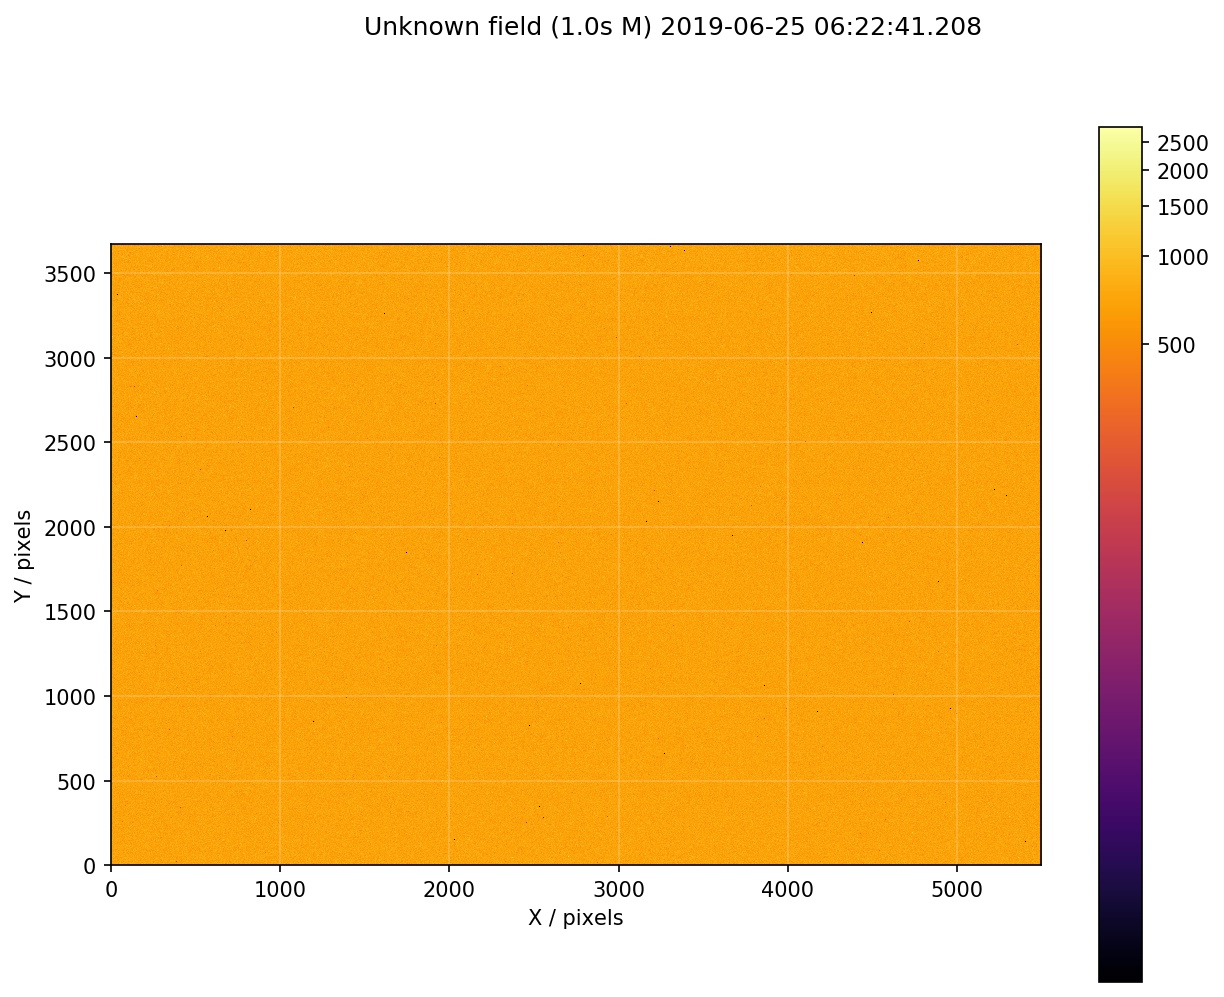

In [94]:
Image(filename=test_jpg, width=250)

### Test camera properties

In [98]:
# Get the CCD temp
cam0.ccd_temp

<Quantity 19. deg_C>

In [97]:
# Turn on the fan
cam0.ccd_cooling_enabled = True